<a href="https://colab.research.google.com/github/sriharshams/cs498aml/blob/master/homework%25201/1a/colab/homework_1_1a_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1: Classification With Naive Bayes



## Problem 1: Diabetes Classification

Points: 40

A famous collection of data on whether a patient has diabetes, known as the Pima Indians dataset, and originally owned by the National Institute of Diabetes and Digestive and Kidney Diseases can be found at Kaggle. Download this dataset from https://www.kaggle.com/kumargh/pimaindiansdiabetescsv. This data has a set of attributes of patients, and a categorical variable telling whether the patient is diabetic or not. For several attributes in this data set, a value of 0 may indicate a missing value of the variable. There are a total of 767 data-points.



## Part 1A 
Build a simple naive Bayes classifier to classify this data set. You should use a normal distribution to model each of the class-conditional distributions.

Compute an estimate of the accuracy of the classifier by averaging over 10 test-train splits. Each split should randomly assign 20% of the data to test, and the rest to train.
You should write this classifier and the test-train split code yourself (it's quite straight-forward).  Libraries can be used to load & hold the data.


### Answer Part 1A

To build a somple naive Bayes classifier to classify Pima Indians dataset. We will be using Python 3 in Google Colab.



#### Set up

Load required libraries


In [0]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm

import pandas_profiling

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#### Load dataset

Access https://www.kaggle.com/kumargh/pimaindiansdiabetescsv, download the dataset, it will download pimaindiansdiabetescsv.zip.





##### Dataset dictionary

Following are the datset details as per kaggle.

About this file
This dataset describes the medical records for Pima Indians and whether or not each patient will have an onset of diabetes within ve years.

Fields description follow:

preg = Number of times pregnant

plas = Plasma glucose concentration a 2 hours in an oral glucose tolerance test

pres = Diastolic blood pressure (mm Hg)

skin = Triceps skin fold thickness (mm)

test = 2-Hour serum insulin (mu U/ml)

mass = Body mass index (weight in kg/(height in m)^2)

pedi = Diabetes pedigree function

age = Age (years)

class = Class variable (1:tested positive for diabetes, 0: tested negative for diabetes)



Columns, first row is sample data, ignoring to obtain dataset of rows 767, as mentioned in home work assignment link.

6 Pregnancies

148 Glucose

72 BloodPressure

35 SkinThickness

0 Insulin

33.6 BMI

0.627 DiabetesPedigreeFunction

50 Age

1 Class



To access the dataset in Google Colab you can either use Github or Google Drive. We will be accessing dataset via Google Drive. Unzip the pimaindiansdiabetescsv.zip, add pima-indians-diabetes.csv to a known folder in Google Drive, this folder path in drive will be accessed later to load dataset.


We added the pima-indians-diabetes.csv to Google Drive folder /My Drive/UISC-MCS-DS/CS498AML/homework_1/1a/data/.

*   Mount Google Drive to access data Note: This is not required if you are not using Google colab



In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Load pima-indians-diabetes.csv Dataset and save it as a pickle object

In [0]:
pima_indias_diabetes_data = pd.read_csv("/content/gdrive/My Drive/UIUC-MCS-DS/CS498AML/homework_1/1a/data/pima-indians-diabetes.csv")
pickle.dump(pima_indias_diabetes_data, open( '/content/gdrive/My Drive/UIUC-MCS-DS/CS498AML/homework_1/1a/data/pima_indias_diabetes_data.pkl','wb'))
pima_indias_diabetes_data.head()

,6,148,72,35,0,33.6,0.627,50,1
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0


#### Exploratory Data Analysis



##### Validate dataset

In [0]:
# rename column names
pima_indias_diabetes_data.columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Class']
pima_indias_diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Class
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0


In [0]:
# count number of dataset
print("There are a total of", len(pima_indias_diabetes_data),"data-points")

There are a total of 767 data-points


In [0]:
pima_indias_diabetes_data_features = pima_indias_diabetes_data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
pima_indias_diabetes_data_labels = pima_indias_diabetes_data[['Class']]
print(pima_indias_diabetes_data_features.shape)
print(pima_indias_diabetes_data_labels.shape)

(767, 8)
(767, 1)


There are 767 observations of 8 different features.



##### Analyse label

Class
0    500
1    267
Name: Class, dtype: int64

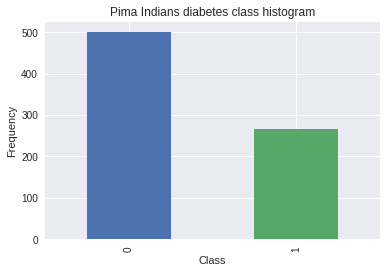

In [0]:
count_classes = pd.value_counts(pima_indias_diabetes_data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Pima Indians diabetes class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

# 284315 normal transactions (class 0)
# 492 fraud transactions (class 1)

pima_indias_diabetes_data.groupby('Class')['Class'].count()

There are 500 Pima Indians 0: tested negative for diabetes, 267 :tested positive for diabetes. 

##### Data distribution analysis for each feature and class label

Plot the data by each feature

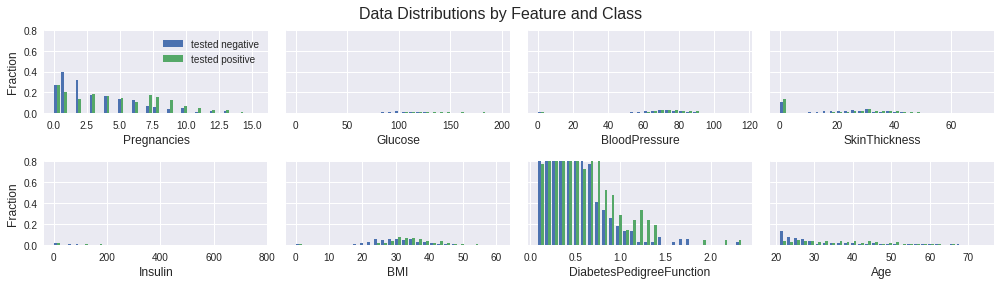

In [0]:
axarr = [[]]*len(pima_indias_diabetes_data_features.columns)
columns = 4
rows = int( np.ceil( len(pima_indias_diabetes_data_features.columns) / columns ) )
f, fig = plt.subplots( figsize=(columns*3.5, rows*2) )

f.suptitle('Data Distributions by Feature and Class', size=16)

for i, col in enumerate(pima_indias_diabetes_data_features.columns[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    axarr[i].hist( [ pima_indias_diabetes_data.loc[ pima_indias_diabetes_data.Class == 0, col ], pima_indias_diabetes_data.loc[ pima_indias_diabetes_data.Class == 1, col ] ], label=['tested negative','tested positive'], 
                          bins=np.linspace( np.percentile(pima_indias_diabetes_data[col],0.1), np.percentile(pima_indias_diabetes_data[col],99.9), 30 ),
                          normed=True )
    axarr[i].set_xlabel(col, size=12)
    axarr[i].set_ylim([0,0.8])
    axarr[i].tick_params(axis='both', labelsize=10)
    if i == 0: 
        legend = axarr[i].legend()
        legend.get_frame().set_facecolor('white')
    if i%4 != 0 : 
        axarr[i].tick_params(axis='y', left='off', labelleft='off')
    else:
        axarr[i].set_ylabel('Fraction',size=12)

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
plt.show()

#### Classify Dataset - Build a simple naive Bayes classifier 

##### Split data


In [0]:

def train_test_split(features, labels, test_size=0.2):
    np.random.seed(4)
    id = np.random.rand(len(features))>test_size
    #print(id)
    features_train = features[id]
    labels_train = labels[id]
    features_test = features[np.invert(id)]
    labels_test = labels[np.invert(id)]
    return features_train, labels_train, features_test, labels_test


features = pima_indias_diabetes_data.drop('Class', axis = 1)
labels = pima_indias_diabetes_data['Class']





#### Gaussian Naive Bayes classifier

In Gaussian Naive Bayes, continuous values associated with each feature are assumed to be distributed according to a Gaussian distribution. A Gaussian distribution is also called Normal distribution. 

The likelihood of the features is assumed to be Gaussian, hence, conditional probability is given by:

 >$P(x_i | y) = \frac{1}{\sqrt{2\pi\sigma _{y}^{2} }} exp \left (-\frac{(x_i-\mu _{y})^2}{2\sigma _{y}^{2}}  \right ) $
 
 we will use norm.pdf to calculate probablity density function.

In [0]:
class GaussianNaiveBayes():
    """The Gaussian Naive Bayes classifier. """
    def fit(self,features, labels):
      """
      for each label and feature combination we need to calculate the std and mean value from the features & labels.
      """
      self.min_std = 0.00000001
      self.ntargets= np.unique(labels).shape[0]
      self.target_labels = np.unique(labels)
      self.nfeatures = features.shape[1]
      self.means = np.zeros((self.ntargets,self.nfeatures))
      self.stds = np.zeros((self.ntargets,self.nfeatures))
      self.priors = np.zeros(self.ntargets)
      for _index in range(self.ntargets):
          # Get the boolean vector to filter for labels = i
          where_label = [label==self.target_labels[_index] for label in labels]
          self.means[_index] = np.nanmean(features[where_label],axis=0)
          # To avoid devide by 0/very small value issue, add a min for standard deviation to min_std = 0.00000001
          self.stds[_index] = np.clip(np.nanstd(features[where_label],axis=0),self.min_std,None)
          #print(self.means[_index], self.stds[_index])
          #Calculate the prior for given label 
          self.priors[_index] = np.log(np.sum(where_label)/len(labels))
    
    def predict(self,test_features):
        """ Classification using Bayes Rule P(Y|X) = P(X|Y)*P(Y)/P(X),
          or Posterior = Likelihood * Prior / Scaling Factor
          P(Y|X) - The posterior is the probability that sample x is of class y given the
                   feature values of x being distributed according to distribution of y and the prior.
          P(X|Y) - Likelihood of data X given class distribution Y.
                   Gaussian distribution (given by _calculate_likelihood)
          P(Y)   - Prior (given by _calculate_prior)
          P(X)   - Scales the posterior to make it a proper probability distribution.
                   This term is ignored in this implementation since it doesn't affect
                   which class distribution the sample is most likely to belong to.
      Classifies the sample as the class that results in the largest P(Y|X) (posterior)
      """
        test_samples = test_features.shape[0]
        posterior = np.zeros((test_samples,self.ntargets))
        # Naive assumption (independence):
        # P(x1,x2,x3|Y) = P(x1|Y)*P(x2|Y)*P(x3|Y)
        # Posterior is product of prior and likelihoods (ignoring scaling factor)
        for target_label in range(self.ntargets):
            posterior[:,target_label] = self.priors[target_label] + np.nansum(np.log(norm.pdf(test_features,self.means[target_label],self.stds[target_label])),axis=1)
        label = self.target_labels[np.argmax(posterior, axis=1)]
        return label    
        
    
    def score(self,X_test, y_test):
        y_predict = self.predict(X_test)
        return (y_predict == y_test).mean()

Compute an estimate of the accuracy of the classifier by averaging over 10 test-train splits. Each split should randomly assign 20% of the data to test, and the rest to train.

In [0]:
print(features.shape)



test_accuracy_iterations =[]
# for 10 iterations
for i in range(10):
  features_train, labels_train, features_test, labels_test = train_test_split(features.values, 
                                 labels.values, test_size=0.2)
  nb = GaussianNaiveBayes()

  nb.fit(features_train, labels_train)
  test_accuracy = nb.score(features_test, labels_test)
  test_accuracy_iterations.append(test_accuracy)

print(test_accuracy_iterations)
print("Average test accuracy", np.mean(test_accuracy_iterations))

(767, 8)
[0.7724550898203593, 0.7724550898203593, 0.7724550898203593, 0.7724550898203593, 0.7724550898203593, 0.7724550898203593, 0.7724550898203593, 0.7724550898203593, 0.7724550898203593, 0.7724550898203593]
Average test accuracy 0.7724550898203593


Validate using scikit learn naive bayes

In [0]:
from sklearn import naive_bayes

test_accuracy_iterations =[]
# for 10 iterations
for i in range(10):
  features_train, labels_train, features_test, labels_test = train_test_split(features.values, labels.values, test_size=0.2)
  snb = naive_bayes.GaussianNB()

  snb.fit(features_train, labels_train)
  test_accuracy = snb.score(features_test, labels_test)
  test_accuracy_iterations.append(test_accuracy)

print(test_accuracy_iterations)
print("Average test accuracy", np.mean(test_accuracy_iterations))

[0.7724550898203593, 0.7724550898203593, 0.7724550898203593, 0.7724550898203593, 0.7724550898203593, 0.7724550898203593, 0.7724550898203593, 0.7724550898203593, 0.7724550898203593, 0.7724550898203593]
Average test accuracy 0.7724550898203593


## Part 1B

Now adjust your code so that, for attribute 3 (Diastolic blood pressure), attribute 4 (Triceps skinfold thickness), attribute 6 (Body mass index), and attribute 8 (Age), it regards a value of 0 as a missing value when estimating the class-conditional distributions, and the posterior. 

*   Compute an estimate of the accuracy of the classifier by averaging over 10 test-train splits.




### Answer Part 1B

All the above work done for Part 1A will be reused for Part 1B.

We will mainly be processing data to remove missing values which are 0.

Impute missing values 0 for attributes 3 (Diastolic blood pressure), attribute 4 (Triceps skinfold thickness), attribute 6 (Body mass index), and attribute 8 (Age) as np.NaN.

Check how many missing values are present.

In [0]:
pima_indias_diabetes_data[['BloodPressure','SkinThickness','BMI','Age']]= pima_indias_diabetes_data[['BloodPressure','SkinThickness','BMI','Age']].replace(0, np.NaN)

print(pima_indias_diabetes_data.isnull().sum())

Pregnancies                   0
Glucose                       0
BloodPressure                35
SkinThickness               227
Insulin                       0
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Class                         0
dtype: int64


In [0]:
#pima_indias_diabetes_data.dropna(inplace=True)

print(pima_indias_diabetes_data.isnull().sum())


Pregnancies                   0
Glucose                       0
BloodPressure                35
SkinThickness               227
Insulin                       0
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Class                         0
dtype: int64


In [0]:
pima_indias_diabetes_data.shape

(767, 9)

After processing the missing  data split data and build new model with new train dataset and test he accuracy.

In [0]:
processed_features = pima_indias_diabetes_data.drop('Class', axis = 1)
processed_labels = pima_indias_diabetes_data['Class']

#scaler = StandardScaler()
#normal_processed_features = scaler.fit_transform(processed_features)

In [0]:
processed_test_accuracy_iterations =[]
# for 10 iterations
for i in range(10):
  p_features_train, p_labels_train, p_features_test, p_labels_test = train_test_split(processed_features.values, processed_labels.values, test_size=0.2)
  p_nb = GaussianNaiveBayes()

  p_nb.fit(p_features_train, p_labels_train)
  p_test_accuracy = p_nb.score(p_features_test, p_labels_test)
  processed_test_accuracy_iterations.append(p_test_accuracy)

print(processed_test_accuracy_iterations)
print("Average test accuracy for processed data", np.mean(processed_test_accuracy_iterations))

[0.7425149700598802, 0.7425149700598802, 0.7425149700598802, 0.7425149700598802, 0.7425149700598802, 0.7425149700598802, 0.7425149700598802, 0.7425149700598802, 0.7425149700598802, 0.7425149700598802]
Average test accuracy for processed data 0.7425149700598802


## References
Following are various resources referred while writing this solution

*   Github projects https://github.com/sriharshams/mlnd/
*   Code of codyznash https://github.com/codyznash/GANs_for_Credit_Card_Data
*   Tutorials of https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/
*   [Naive Bayes in Scikit-Learn](https://github.com/scikit-learn/scikit-learn/blob/7389dba/sklearn/naive_bayes.py#L107): Implementation of naive bayes in the scikit-learn library.
*   [ ML from scratch] (https://github.com/eriklindernoren/ML-From-Scratch)
*   [Naive Bayes documentation](https://scikit-learn.org/stable/modules/naive_bayes.html): Scikit-Learn documentation and sample code for Naive Bayes
*   Naive Bayes Classifiers https://www.geeksforgeeks.org/naive-bayes-classifiers/
*   [Naive Bayes Classifier From Scratch](https://chrisalbon.com/machine_learning/naive_bayes/naive_bayes_classifier_from_scratch/)
*   https://chrisalbon.com/machine_learning/naive_bayes/naive_bayes_classifier_from_scratch/
*   Naive Bayes from scratch in python http://kenzotakahashi.github.io/naive-bayes-from-scratch-in-python.html
*   [Applied Machine Learning, D.A. Forsyth, (approximate 18'th draft)](http://luthuli.cs.uiuc.edu/~daf/courses/AML-18-Fall/AMLbook-3-Dec-18.pdf)
*   Piazza & Slack discussions on CS-498 Spring 2019



